In [18]:
import pandas as pd

# Load the datasets
collisions = 'C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/UK_road_casualty_collision_1979_2022.csv'
vehicles = 'C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/UK_road_casualty_vehicle_1979_2022.csv'

# Read the CSV files
collisions_data = pd.read_csv(collisions)
vehicles_data = pd.read_csv(vehicles)

C:\Users\loma5202\AppData\Local\Temp\ipykernel_3412\1714511162.py:8: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\loma5202\AppData\Local\Temp\ipykernel_3412\1714511162.py:9: DtypeWarning: Columns (0,2,24,27) have mixed types. Specify dtype option on import or set low_memory=False.


In [19]:
# Remove unnecessary columns
cols_remove = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force',
               'local_authority_district', 'local_authority_ons_district', 'local_authority_highway',
               'first_road_number', 'second_road_number', 'pedestrian_crossing_human_control',
               'trunk_road_flag', 'lsoa_of_accident_location']

cols_save = ['accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'vehicle_type',
             'sex_of_driver', 'age_of_driver', 'engine_capacity_cc', 'age_of_vehicle']

collisions_data = collisions_data.drop(cols_remove, axis = 1)
vehicles_data = vehicles_data[cols_save]

In [20]:
# Joining the datasets on 'accident_index'
road_acc_data = pd.merge(collisions_data, vehicles_data, on = 'accident_index', how = 'inner')

In [21]:
road_acc_data.head(1)

,accident_index,accident_year_x,accident_reference_x,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,...,urban_or_rural_area,did_police_officer_attend_scene_of_accident,accident_year_y,accident_reference_y,vehicle_reference,vehicle_type,sex_of_driver,age_of_driver,engine_capacity_cc,age_of_vehicle
0,197901A11AD14,1979,01A11AD14,3,2,1,18/01/1979,5,08:00,3,...,-1,-1,1979,01A11AD14,1,109,1,44,-1,-1


In [23]:
# Remove unnecessary columns from combined data frame
cols_remove = ['accident_reference_x', 'accident_reference_y', 'accident_year_y', 'vehicle_reference']

road_acc_data = road_acc_data.drop(cols_remove, axis = 1)
road_acc_data.rename(columns = {'accident_year_x': 'accident_year'}, inplace = True)

In [27]:
# Re-classifying vehicle_type (all motorcycles in one group, cars + taxi in one group, etc.)
# Creating a mapping function for the vehicle_type groups
def map_vehicle_type(value):
    if value in [2, 3, 4, 5, 97, 104, 105, 106]: # All motorcycle versions (independent of cc)
        return 2
    elif value in [8, 9, 108, 109]: # Cars, taxis and private hire cars
        return 8
    elif value in [20, 21, 113]: # All goods over 3.5 tonnes in one group
        return 20
    elif value in [-1, 90, 98, 99]: # All unknown/other vehicles in one group
        return 90
    elif value in [10, 110]: # Minibuses
        return 10
    else:
        return value

# Applying the mapping function to the vehicle_type column
road_acc_data['vehicle_type_grouped'] = road_acc_data['vehicle_type'].apply(map_vehicle_type)

# Checking the modification by displaying the first few rows
road_acc_data[['vehicle_type', 'vehicle_type_grouped']].head(10)


,vehicle_type,vehicle_type_grouped
0,109,8
1,104,2
2,109,8
3,109,8
4,109,8
5,109,8
6,109,8
7,109,8
8,109,8
9,109,8


In [29]:
# Save the combined dataframe to avoid having to redo the first pre-processing steps every time
road_acc_data.to_csv('C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/combined_collision_vehicle_1979_2022.csv', index = False)

**If restarting, can start from here**

In [80]:
import pandas as pd

road_acc_data = pd.read_csv('C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/combined_collision_vehicle_1979_2022.csv')

C:\Users\loma5202\AppData\Local\Temp\ipykernel_3412\3483892284.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


**Accidents/casualties vs type of vehicle**

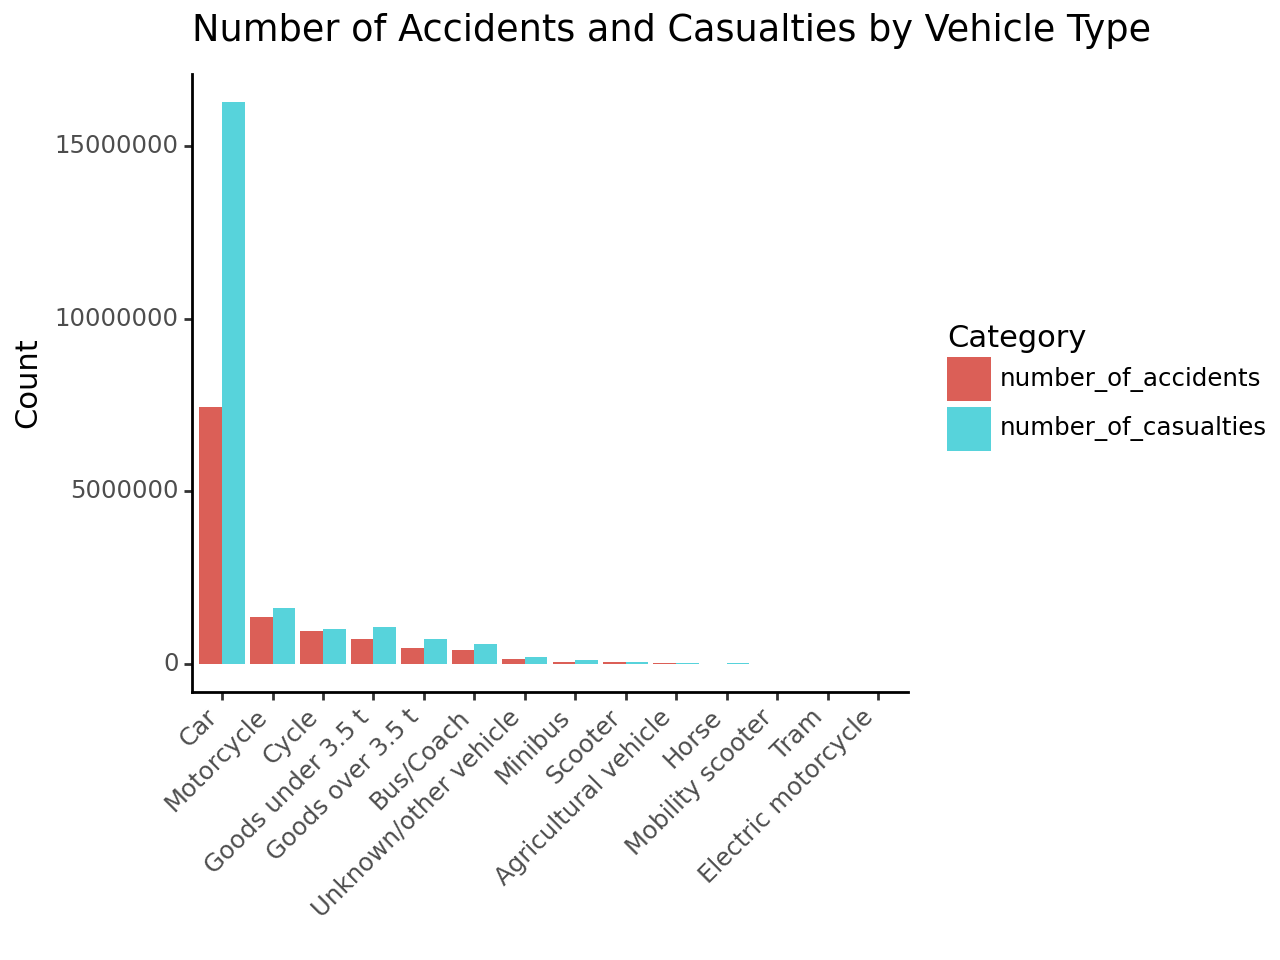

<Figure Size: (640 x 480)>

In [83]:
from plotnine import *

# Count unique accidents and sum casualties for each vehicle type
vehicle_type_data = road_acc_data.groupby('vehicle_type_grouped').agg({'accident_index': pd.Series.nunique, 
                                                       'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
vehicle_type_data.columns = ['vehicle_type_grouped', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'vehicle_type_grouped' values to names, including -1 as 'Unknown/other vehicle'
vehicle_type_mapping = {
    1: "Cycle", 2: "Motorcycle", 8: "Car", 10: "Minibus", 11: "Bus/Coach",
    16: "Horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Goods under 3.5 t",
    20: "Goods over 3.5 t", 22: "Mobility scooter", 23: "Electric motorcycle",
    90: "Unknown/other vehicle", 103: "Scooter"
}

vehicle_type_data['vehicle_type_grouped'] = vehicle_type_data['vehicle_type_grouped'].map(vehicle_type_mapping)

# Melting the DataFrame for use in plotnine
vehicle_type_data = vehicle_type_data.melt(id_vars='vehicle_type_grouped', var_name='Category', value_name='Count')

# Creating the plot
vehicle_type_plot = (
    ggplot(vehicle_type_data, aes(x='reorder(vehicle_type_grouped, -Count)', y='Count', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='', y='Count', title='Number of Accidents and Casualties by Vehicle Type') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
vehicle_type_plot

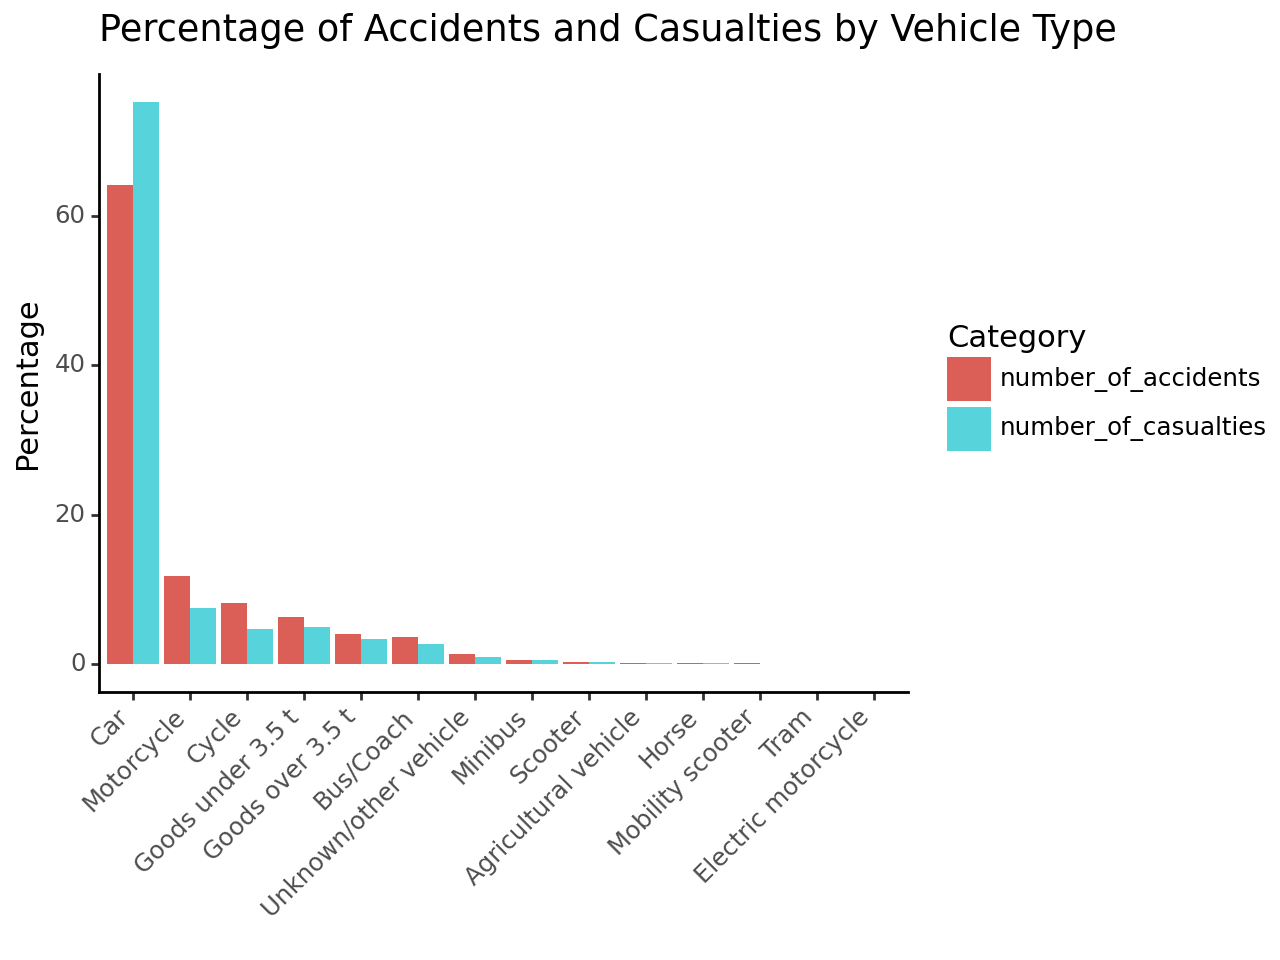

<Figure Size: (640 x 480)>

In [40]:
# Relative comparison of accidents and casualties for each vehicle type

# Count unique accidents and sum casualties for each vehicle type (same as before)
df_plot_vehicle_type = road_acc_data.groupby('vehicle_type_grouped').agg({'accident_index': pd.Series.nunique, 
                                                       'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
df_plot_vehicle_type.columns = ['vehicle_type_grouped', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'vehicle_type_grouped' values to names, including -1 as 'Unknown/other vehicle'
vehicle_type_mapping = {
    1: "Cycle", 2: "Motorcycle", 8: "Car", 10: "Minibus", 11: "Bus/Coach",
    16: "Horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Goods under 3.5 t",
    20: "Goods over 3.5 t", 22: "Mobility scooter", 23: "Electric motorcycle",
    90: "Unknown/other vehicle", 103: "Scooter"
}

df_plot_vehicle_type['vehicle_type_grouped'] = df_plot_vehicle_type['vehicle_type_grouped'].map(vehicle_type_mapping)

# Calculate total counts
total_accidents = df_plot_vehicle_type['number_of_accidents'].sum()
total_casualties = df_plot_vehicle_type['number_of_casualties'].sum()

# Compute relative counts (percentages)
df_plot_vehicle_type['number_of_accidents'] = (df_plot_vehicle_type['number_of_accidents'] / total_accidents) * 100
df_plot_vehicle_type['number_of_casualties'] = (df_plot_vehicle_type['number_of_casualties'] / total_casualties) * 100

# Melting the DataFrame for use in plotnine
df_plot_vehicle_type = df_plot_vehicle_type.melt(id_vars='vehicle_type_grouped', var_name='Category', value_name='Percentage')

# Creating the plot with relative counts
vehicle_type_plot = (
    ggplot(df_plot_vehicle_type, aes(x='reorder(vehicle_type_grouped, -Percentage)', y='Percentage', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='', y='Percentage', title='Percentage of Accidents and Casualties by Vehicle Type') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
vehicle_type_plot



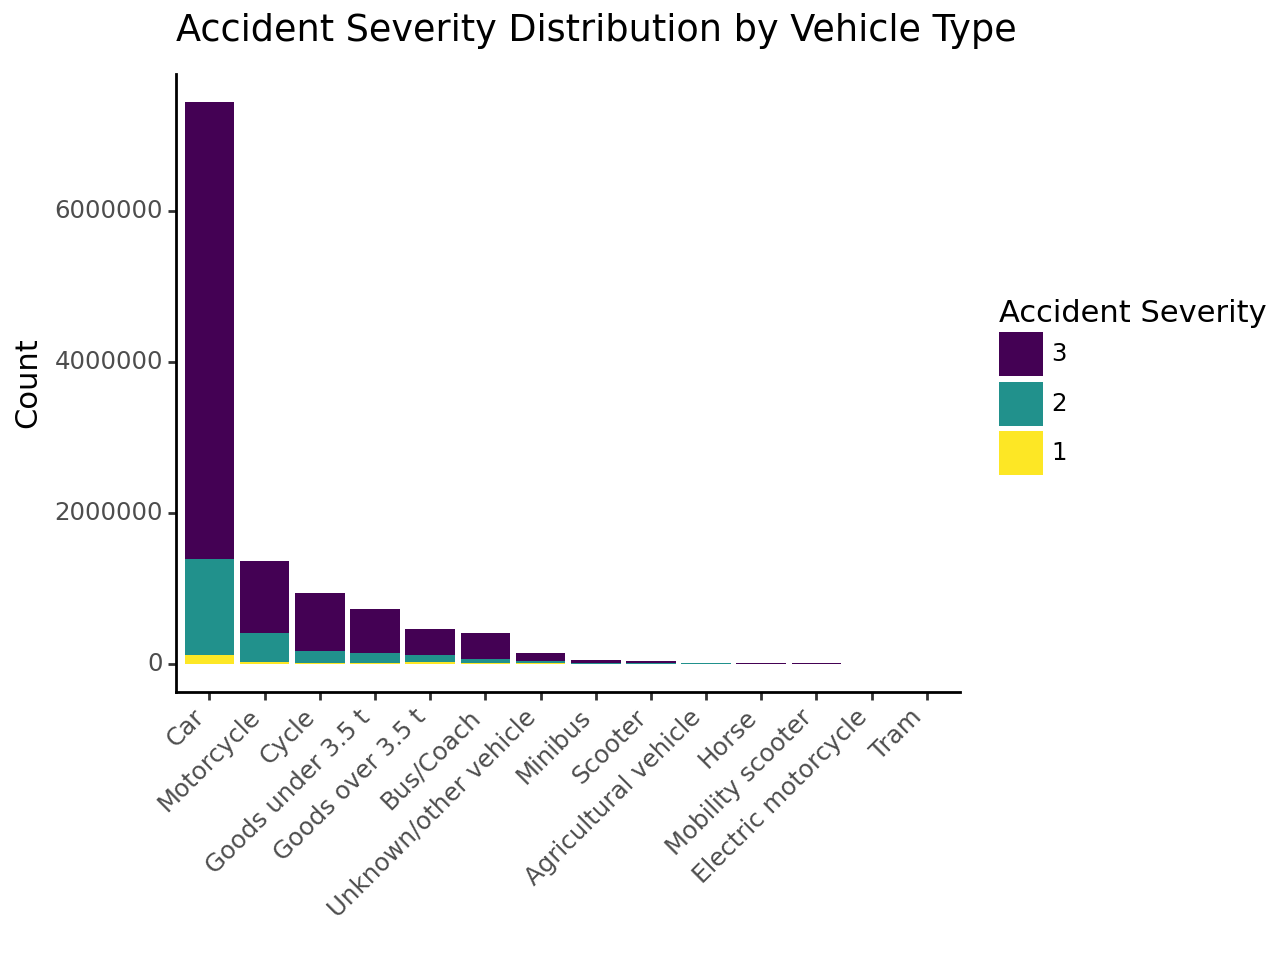

<Figure Size: (640 x 480)>

In [102]:
# Distribution of accident severity for different vehicles 

# Prepare the data: group by vehicle type and accident severity, and count the number of accidents
vehicle_type_severity_data = road_acc_data.groupby(['vehicle_type_grouped', 'accident_severity'])['accident_index'].nunique().reset_index(name='count')


vehicle_type_severity_data['accident_severity'] = pd.Categorical(vehicle_type_severity_data['accident_severity'], 
                                                                 categories=[3, 2, 1], ordered=True)

# Calculate total accidents per vehicle type for ordering
total_accidents_per_vehicle = vehicle_type_severity_data.groupby('vehicle_type_grouped')['count'].sum().reset_index()
total_accidents_per_vehicle = total_accidents_per_vehicle.sort_values(by='count', ascending=False)

# Merge total counts back to severity data for ordering
vehicle_type_severity_data = vehicle_type_severity_data.merge(total_accidents_per_vehicle, 
                                                              on='vehicle_type_grouped', suffixes=('', '_total'))


# Map 'vehicle_type_grouped' values to names
vehicle_type_mapping = {
    1: "Cycle", 2: "Motorcycle", 8: "Car", 10: "Minibus", 11: "Bus/Coach",
    16: "Horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Goods under 3.5 t",
    20: "Goods over 3.5 t", 22: "Mobility scooter", 23: "Electric motorcycle",
    90: "Unknown/other vehicle", 103: "Scooter"
}

vehicle_type_severity_data['vehicle_type_grouped'] = vehicle_type_severity_data['vehicle_type_grouped'].map(vehicle_type_mapping)

# Creating the stacked bar plot
vehicle_type_severity_plot = (
    ggplot(vehicle_type_severity_data, aes(x='reorder(vehicle_type_grouped, -count_total)', y='count', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='', y='Count', title='Accident Severity Distribution by Vehicle Type', fill='Accident Severity') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
vehicle_type_severity_plot


I would say these graphs speaks to that we can group vehicles as [Car, Motorcycle, Cycle, Goods under 3.5 t, Goods over 3.5 t, Bus/coach, Unknown/other]

**Accidents/casualties vs sex of driver**

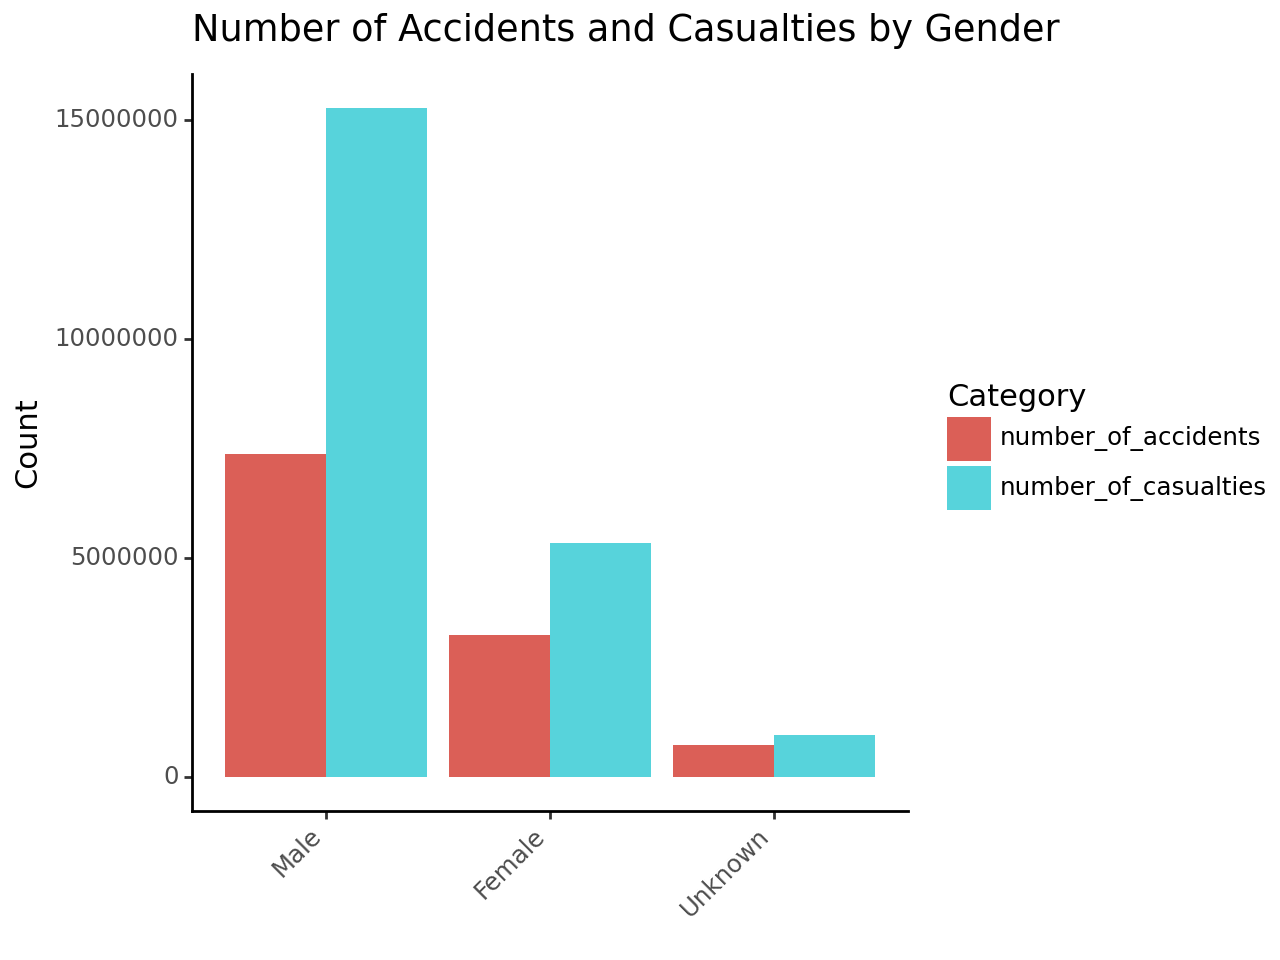

<Figure Size: (640 x 480)>

In [53]:
# Count unique accidents and sum casualties for each vehicle type
gender_data = road_acc_data.groupby('sex_of_driver').agg({'accident_index': pd.Series.nunique,
                                                          'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
gender_data.columns = ['sex_of_driver', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'sex_of_driver' values to names
gender_mapping = {
    1: "Male", 2: "Female", 3: "Unknown", -1: "Unknown"
}

gender_data['sex_of_driver'] = gender_data['sex_of_driver'].map(gender_mapping)

# Melting the DataFrame for use in plotnine
gender_data = gender_data.melt(id_vars='sex_of_driver', var_name='Category', value_name='Count')

# Creating the plot
gender_plot = (
    ggplot(gender_data, aes(x='reorder(sex_of_driver, -Count)', y='Count', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='', y='Count', title='Number of Accidents and Casualties by Gender') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
gender_plot

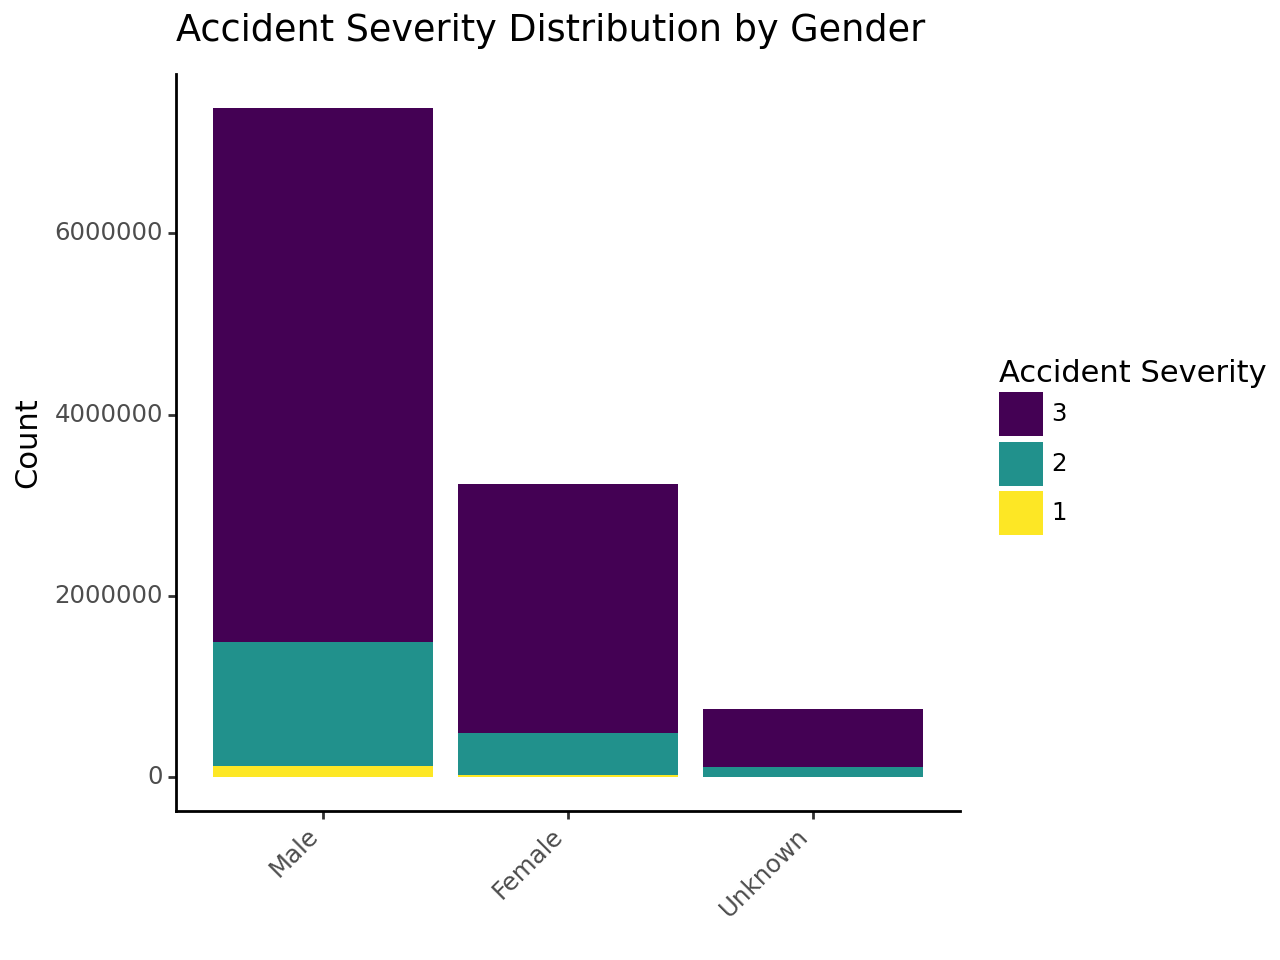

<Figure Size: (640 x 480)>

In [103]:
# Distribution of severity of accidents for different gender of driver

# Prepare the data: group by vehicle type and accident severity, and count the number of accidents
gender_severity_data = road_acc_data.groupby(['sex_of_driver', 'accident_severity'])['accident_index'].nunique().reset_index(name='count')


gender_severity_data['accident_severity'] = pd.Categorical(gender_severity_data['accident_severity'], 
                                                                 categories=[3, 2, 1], ordered=True)

# Calculate total accidents per vehicle type for ordering
total_accidents_per_gender = gender_severity_data.groupby('sex_of_driver')['count'].sum().reset_index()
total_accidents_per_gender = total_accidents_per_gender.sort_values(by='count', ascending=False)

# Merge total counts back to severity data for ordering
gender_severity_data = gender_severity_data.merge(total_accidents_per_gender, 
                                                              on='sex_of_driver', suffixes=('', '_total'))

# Mapping the 'sex_of_driver' values to names
gender_mapping = {
    1: "Male", 2: "Female", 3: "Unknown", -1: "Unknown"
}

gender_severity_data['sex_of_driver'] = gender_severity_data['sex_of_driver'].map(gender_mapping)

# Creating the stacked bar plot
gender_severity_plot = (
    ggplot(gender_severity_data, aes(x='reorder(sex_of_driver, -count_total)', y='count', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='', y='Count', title='Accident Severity Distribution by Gender', fill='Accident Severity') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
gender_severity_plot


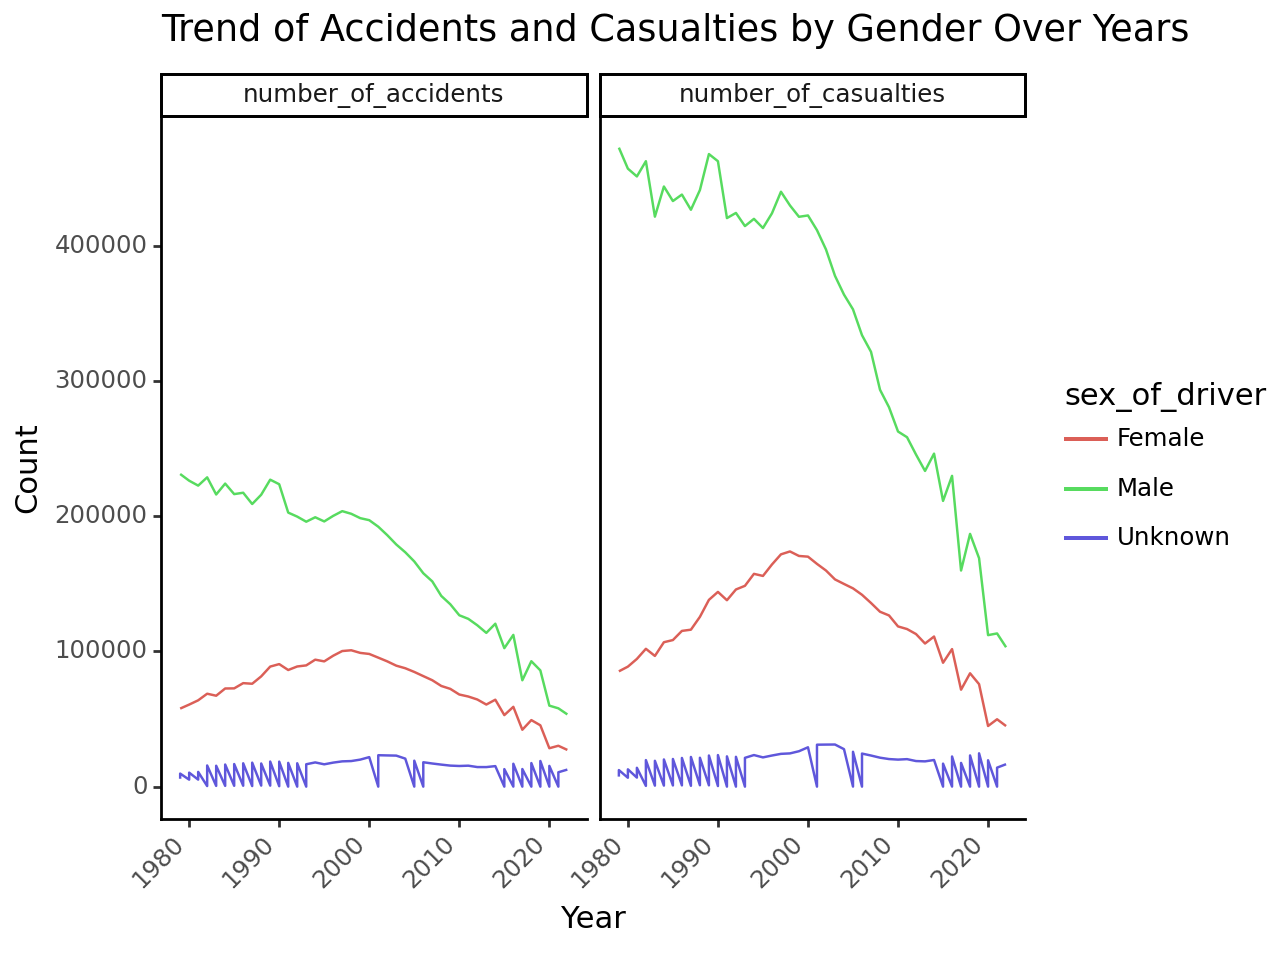

<Figure Size: (640 x 480)>

In [56]:
# Lineplots for showing trends of accidents and casualties, respectively, over time for different gender of driver

# Group by year, sex of driver, and aggregate
gender_year_data = road_acc_data.groupby(['accident_year', 'sex_of_driver']).agg({'accident_index': pd.Series.nunique, 
                                                                                  'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
gender_year_data.columns = ['accident_year', 'sex_of_driver', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'sex_of_driver' values to names
gender_mapping = {
    1: "Male", 2: "Female", 3: "Unknown", -1: "Unknown"
}
gender_year_data['sex_of_driver'] = gender_year_data['sex_of_driver'].map(gender_mapping)

# Melting the DataFrame for use in plotnine
gender_year_data_melted = gender_year_data.melt(id_vars=['accident_year', 'sex_of_driver'], var_name='Category', value_name='Count')

# Creating the line plot with facets for accidents and casualties
gender_line_plot = (
    ggplot(gender_year_data_melted, aes(x='accident_year', y='Count', color='sex_of_driver')) +
    geom_line() +
    facet_wrap('~Category') +  # Separate subplots for accidents and casualties
    labs(x='Year', y='Count', title='Trend of Accidents and Casualties by Gender Over Years') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
gender_line_plot


**Accidents/casualties vs age of driver**

In [63]:
print("max age of driver is", road_acc_data['age_of_driver'].max())
print("min age of driver is", road_acc_data['age_of_driver'].min())

max age of driver is 102
min age of driver is -1


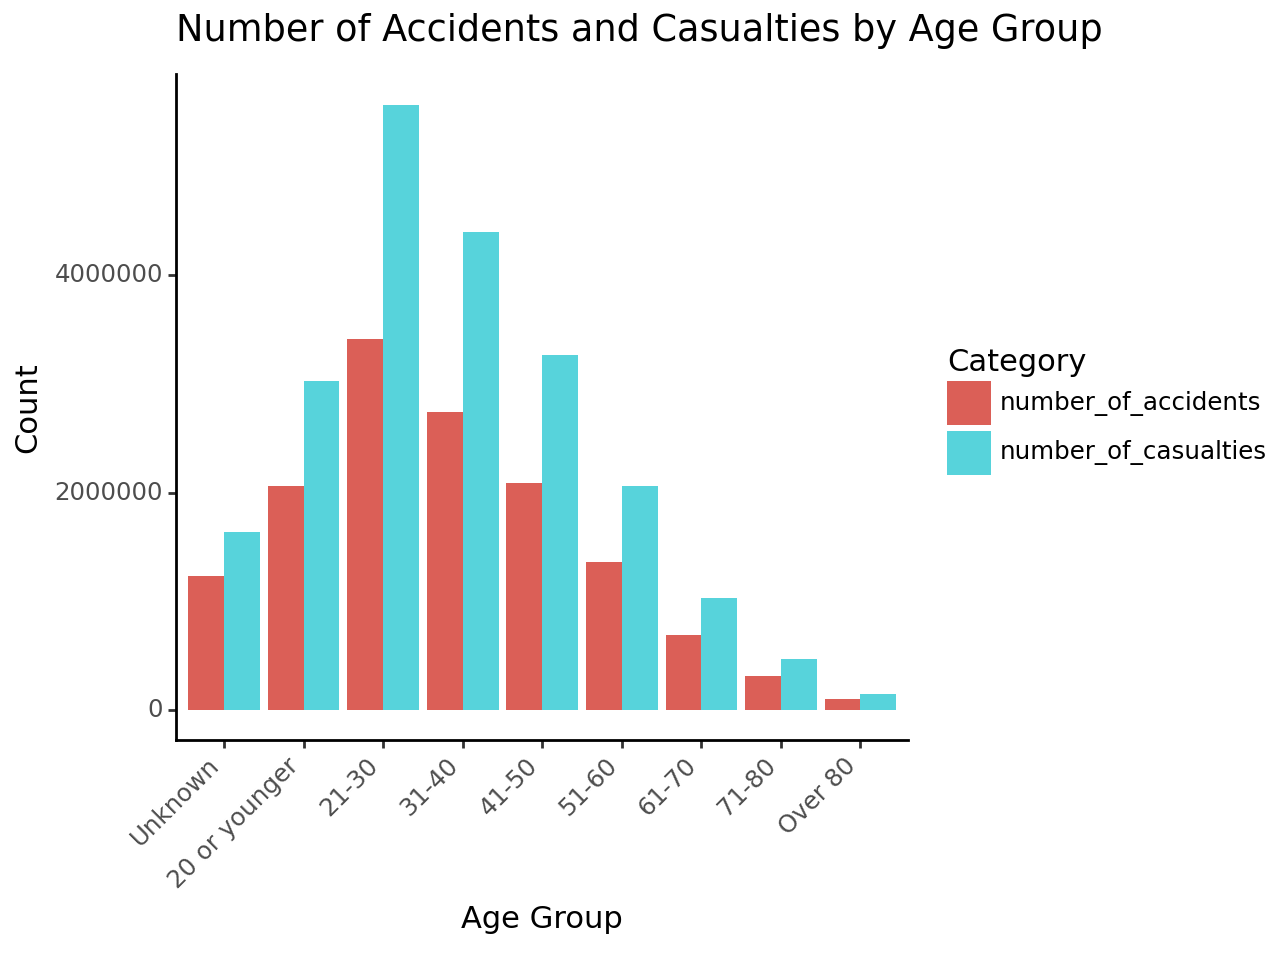

<Figure Size: (640 x 480)>

In [68]:
# Barplot with binned age of driver

# Copy the data
age_data = road_acc_data.copy()

#known_age_data = age_data[age_data['age_of_driver'] != -1]

# Bin ages for rows where age_of_driver 
bins = [-2, -1, 20, 30, 40, 50, 60, 70, 80, 105]  # Adjust as needed
labels = ['Unknown', '20 or younger', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', 'Over 80']
age_data['age_group'] = pd.cut(age_data['age_of_driver'], bins=bins, labels=labels, right=True, include_lowest=True)

# Group by age group and aggregate
age_data = age_data.groupby('age_group').agg({'accident_index': pd.Series.nunique,
                                              'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
age_data.columns = ['age_group', 'number_of_accidents', 'number_of_casualties']

# Melting the DataFrame for use in plotnine
age_data_melted = age_data.melt(id_vars='age_group', var_name='Category', value_name='Count')

# Creating the bar plot
age_plot = (
    ggplot(age_data_melted, aes(x='age_group', y='Count', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Age Group', y='Count', title='Number of Accidents and Casualties by Age Group') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
age_plot


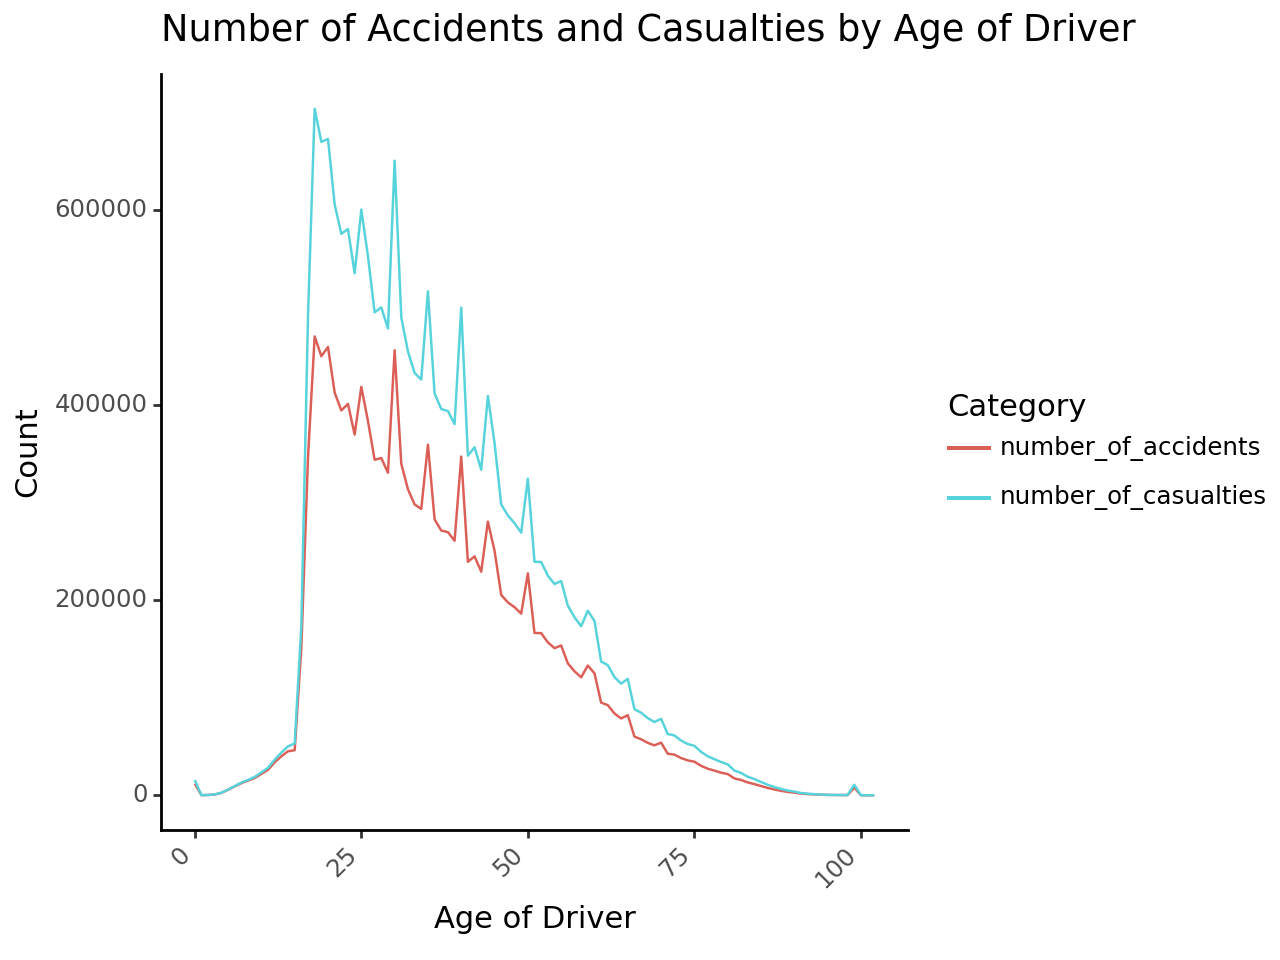

<Figure Size: (640 x 480)>

In [70]:
# line plot
# Filter out unknown ages
known_age_data = road_acc_data[road_acc_data['age_of_driver'] != -1]

# Group by age and aggregate
age_line_data = known_age_data.groupby('age_of_driver').agg({'accident_index': pd.Series.nunique, 
                                                             'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
age_line_data.columns = ['age_of_driver', 'number_of_accidents', 'number_of_casualties']

# Melting the DataFrame for use in plotnine
age_line_data_melted = age_line_data.melt(id_vars='age_of_driver', var_name='Category', value_name='Count')

# Creating the line plot
age_line_plot = (
    ggplot(age_line_data_melted, aes(x='age_of_driver', y='Count', color='Category')) +
    geom_line() +
    labs(x='Age of Driver', y='Count', title='Number of Accidents and Casualties by Age of Driver') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
age_line_plot


In [71]:
print(known_age_data['age_of_driver'].unique())

[ 44  21  31  23  26  18  59  19  17  20  65  16  42  28  41  50  52  14
  53  25  68  60  47  43  39   9  30  27  22  55  40  58  57  34  35  46
  71  29  37  56  13  10  54   8  78  33  11  36  51  38  24  49  45  32
  74  48  70  81  67  62  61  12  69  72  63   7   6  15  84   5  64  66
  75  79  77  73  76   4  80  83  85  82  86  88  90  89  87  95   0  91
  96   3   2   1  92  97  94  93  99  98 100 101 102]


We need to check these values and decide what to do with them.. I don't think someone aged 0 - 14 was driving a car and caused an accident... Maybe someone aged 15 or something could be driving but maybe not so much younger than that?

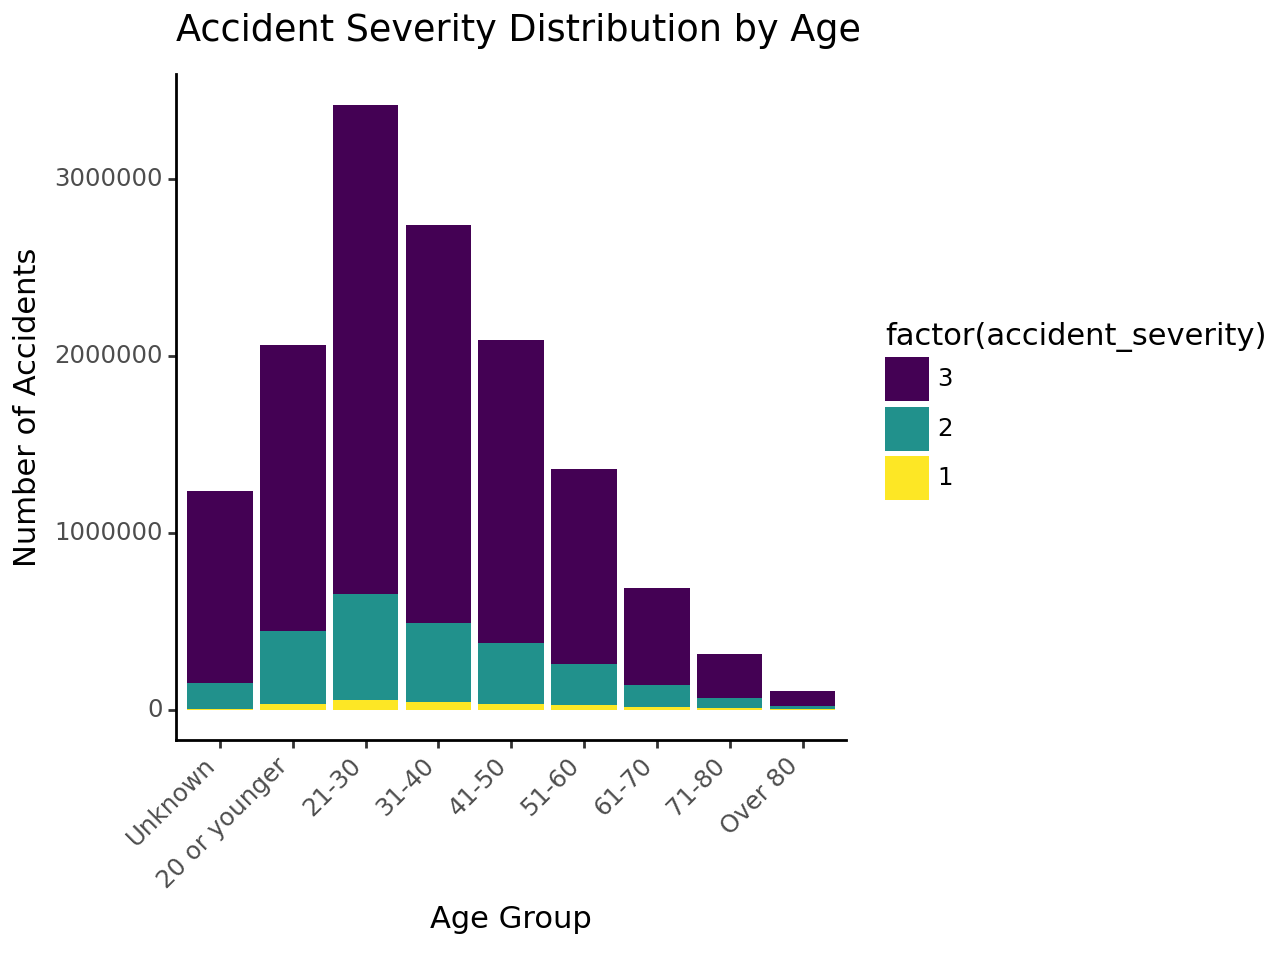

<Figure Size: (640 x 480)>

In [104]:
# Distribution of accident severity per age group
age_data = road_acc_data.copy()

# Bin ages, including -1 as a bin
bins = [-2, -1, 20, 30, 40, 50, 60, 70, 80, 105]  # Adjust as needed
labels = ['Unknown', '20 or younger', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', 'Over 80']
age_data['age_group'] = pd.cut(age_data['age_of_driver'], bins=bins, labels=labels, right=True, include_lowest=True)

# Group by age group and accident severity, and count the number of accidents
age_severity_data = age_data.groupby(['age_group', 'accident_severity'])['accident_index'].nunique().reset_index(name='number_of_accidents')

age_severity_data['accident_severity'] = pd.Categorical(age_severity_data['accident_severity'], 
                                                                 categories=[3, 2, 1], ordered=True)

# Rename columns for clarity
age_severity_data.columns = ['age_group', 'accident_severity', 'number_of_accidents']

# Creating the stacked bar plot, sorted based on number of accidents
age_severity_plot_sort = (
    ggplot(age_severity_data, aes(x='reorder(age_group, -number_of_accidents)', y='number_of_accidents', fill='factor(accident_severity)')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='Age Group', y='Number of Accidents', title='Accident Severity Distribution by Age') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Stacked bar plot, sorted based on age
age_severity_plot = (
    ggplot(age_severity_data, aes(x='age_group', y='number_of_accidents', fill='factor(accident_severity)')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='Age Group', y='Number of Accidents', title='Accident Severity Distribution by Age') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
age_severity_plot


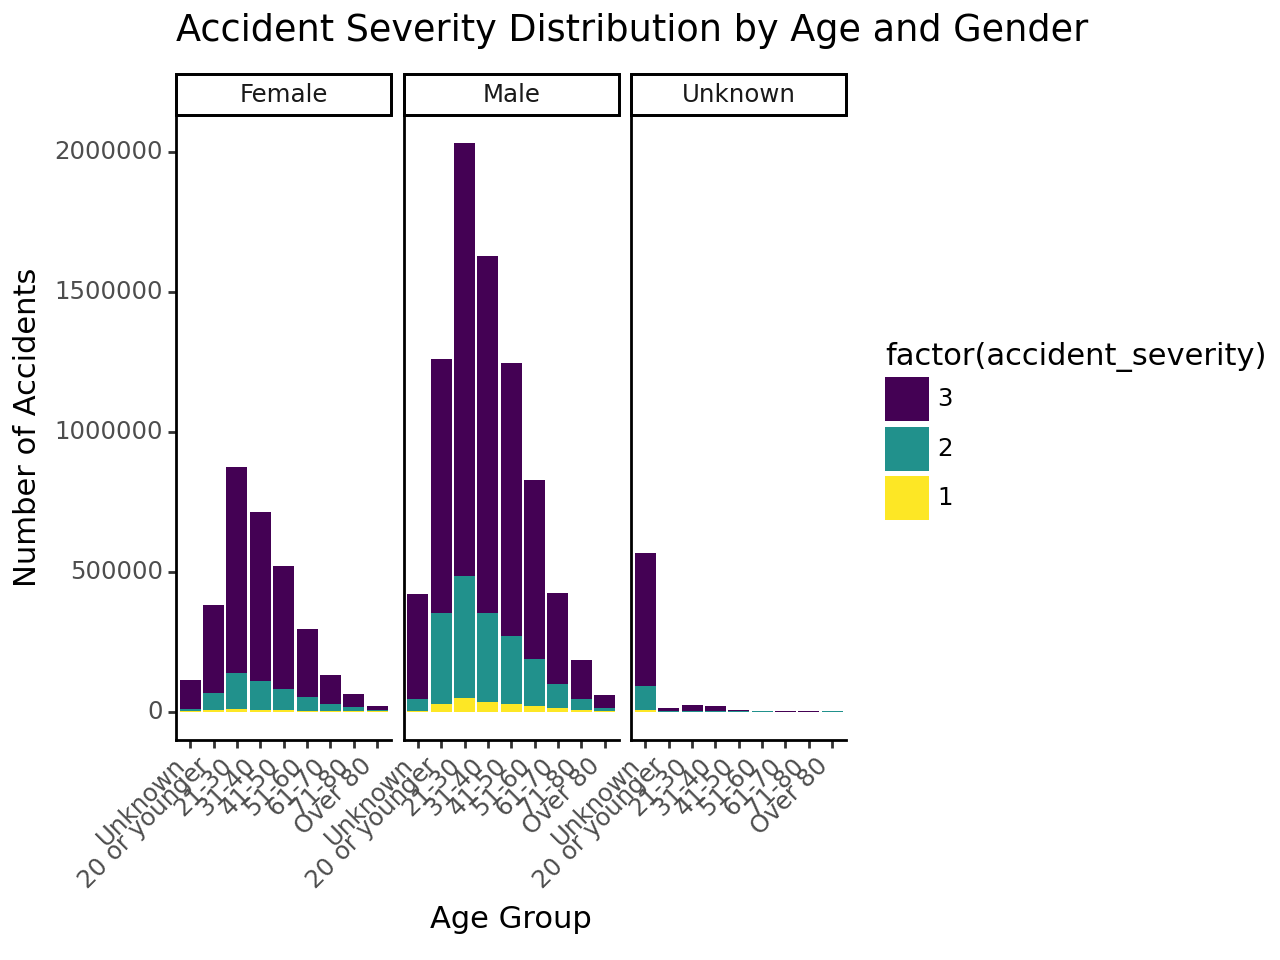

<Figure Size: (640 x 480)>

In [106]:
# Plotting distribution of accidents (with accident severity) based on age and gender of driver

age_gender_data = road_acc_data.copy()

# Bin ages, including -1 as a bin
bins = [-2, -1, 20, 30, 40, 50, 60, 70, 80, 105]  # Adjust as needed
labels = ['Unknown', '20 or younger', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', 'Over 80']
age_gender_data['age_group'] = pd.cut(age_gender_data['age_of_driver'], bins=bins, labels=labels, right=True, include_lowest=True)

age_gender_data['accident_severity'] = pd.Categorical(age_gender_data['accident_severity'], 
                                                                 categories=[3, 2, 1], ordered=True)

# Map gender
gender_mapping = {
    1: "Male", 2: "Female", 3: "Unknown"
}
age_gender_data['sex_of_driver'] = age_gender_data['sex_of_driver'].map(gender_mapping)

# Group by age group, gender, and accident severity
age_gender_data = age_gender_data.groupby(['age_group', 'sex_of_driver', 'accident_severity'])['accident_index'].nunique().reset_index(name='number_of_accidents')

# Creating the grouped bar plot
age_gender_severity_plot = (
    ggplot(age_gender_data, aes(x='age_group', y='number_of_accidents', fill='factor(accident_severity)', group='sex_of_driver')) +
    geom_bar(stat='identity', position=position_dodge(width=0.9)) +
    labs(x='Age Group', y='Number of Accidents', title='Accident Severity Distribution by Age and Gender') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    facet_wrap('~sex_of_driver') 
)

# Display the plot
age_gender_severity_plot


I think we can omit the gender unknown and maybe also the unknown age group?

**Accidents/casualties vs engine capacity**

In [90]:
print(road_acc_data['engine_capacity_cc'].nunique())

5117


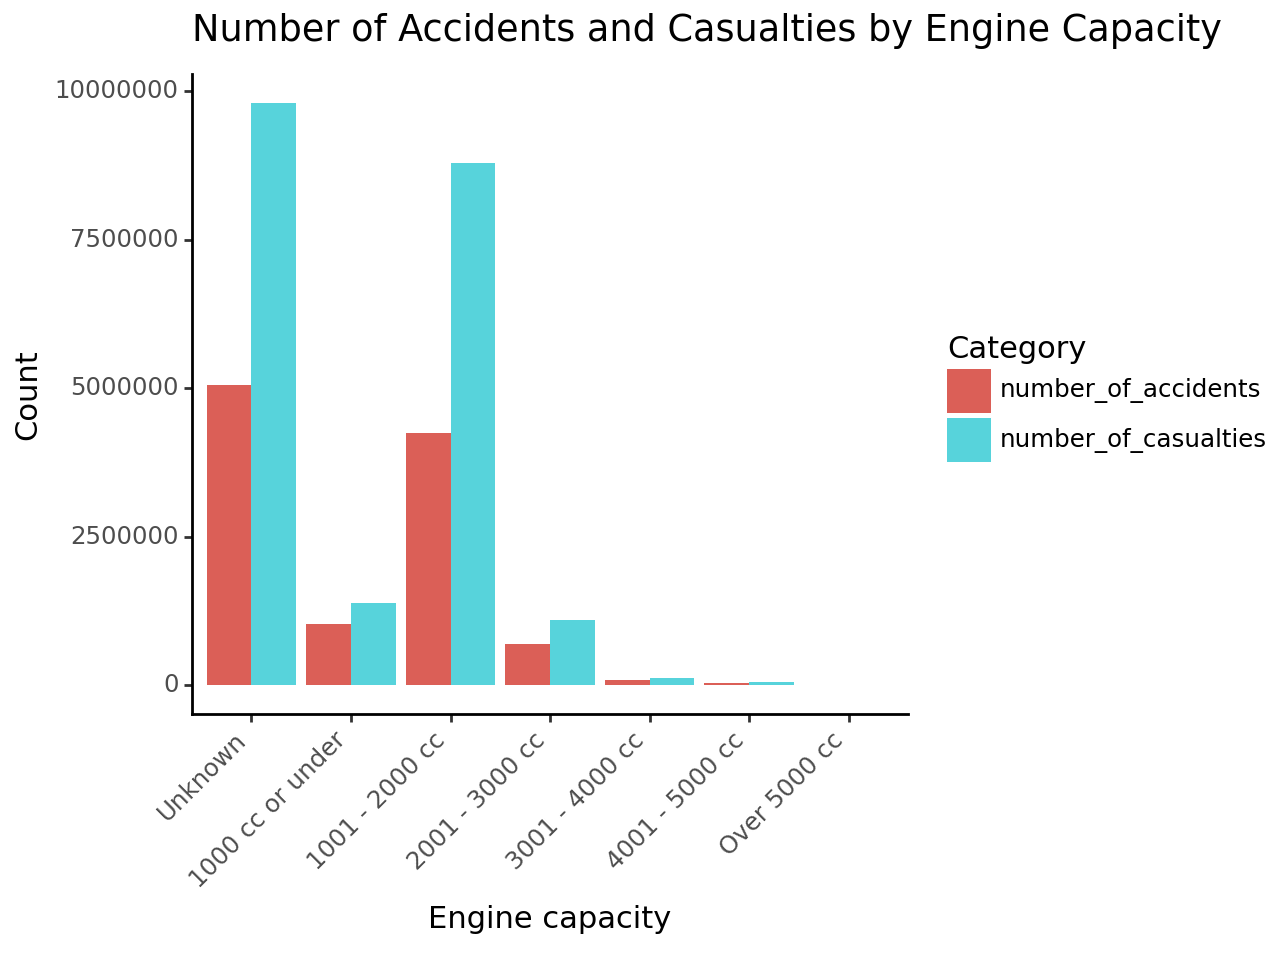

<Figure Size: (640 x 480)>

In [92]:
# Copy the data
engine_capacity_data = road_acc_data.copy()

# Bin engine capacities
bins = [-2, -1, 1000, 2000, 3000, 4000, 5000, 5120]  # Adjust as needed
labels = ['Unknown', '1000 cc or under', '1001 - 2000 cc', '2001 - 3000 cc', '3001 - 4000 cc', 
          '4001 - 5000 cc', 'Over 5000 cc']
engine_capacity_data['engine_cap_group'] = pd.cut(engine_capacity_data['engine_capacity_cc'], bins=bins, 
                                                  labels=labels, right=True, include_lowest=True)

# Group by engine capacity and aggregate
engine_capacity_data = engine_capacity_data.groupby('engine_cap_group').agg({'accident_index': pd.Series.nunique,
                                              'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
engine_capacity_data.columns = ['engine_cap_group', 'number_of_accidents', 'number_of_casualties']

# Melting the DataFrame for use in plotnine
engine_capacity_data_melted = engine_capacity_data.melt(id_vars='engine_cap_group', var_name='Category', value_name='Count')

# Creating the bar plot
engine_capacity_plot = (
    ggplot(engine_capacity_data_melted, aes(x='engine_cap_group', y='Count', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='Engine capacity', y='Count', title='Number of Accidents and Casualties by Engine Capacity') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
engine_capacity_plot

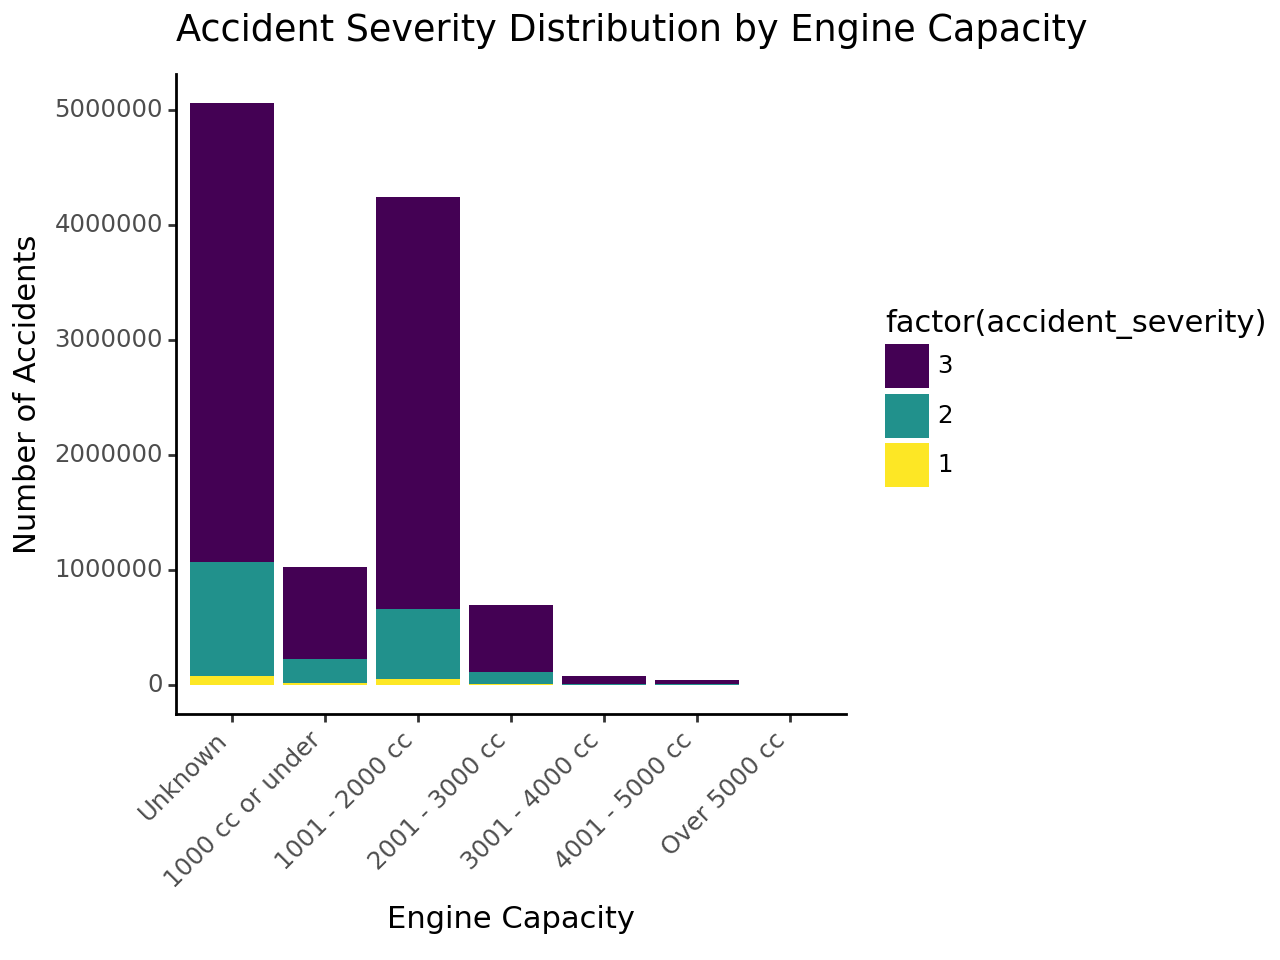

<Figure Size: (640 x 480)>

In [107]:
engine_capacity_data = road_acc_data.copy()

# Bin ages, including -1 as a bin
bins = [-2, -1, 1000, 2000, 3000, 4000, 5000, 5120]  # Adjust as needed
labels = ['Unknown', '1000 cc or under', '1001 - 2000 cc', '2001 - 3000 cc', '3001 - 4000 cc', 
          '4001 - 5000 cc', 'Over 5000 cc']
engine_capacity_data['engine_cap_group'] = pd.cut(engine_capacity_data['engine_capacity_cc'], bins=bins, 
                                                  labels=labels, right=True, include_lowest=True)

# Group by age group and accident severity, and count the number of accidents
eng_cap_severity_data = engine_capacity_data.groupby(['engine_cap_group', 'accident_severity'])['accident_index'].nunique().reset_index(name='number_of_accidents')

eng_cap_severity_data['accident_severity'] = pd.Categorical(eng_cap_severity_data['accident_severity'],
                                                            categories=[3, 2, 1], ordered=True)

# Rename columns for clarity
eng_cap_severity_data.columns = ['engine_cap_group', 'accident_severity', 'number_of_accidents']

# Creating the stacked bar plot, sorted based on number of accidents
eng_cap_severity_plot_sort = (
    ggplot(eng_cap_severity_data, aes(x='reorder(engine_cap_group, -number_of_accidents)', y='number_of_accidents', 
                                      fill='factor(accident_severity)')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='Engine Capacity', y='Number of Accidents', title='Accident Severity Distribution by Engine Capacity') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Stacked bar plot, sorted based on age
eng_cap_severity_plot = (
    ggplot(eng_cap_severity_data, aes(x='engine_cap_group', y='number_of_accidents', fill='factor(accident_severity)')) +
    geom_bar(stat='identity', position='stack') +
    labs(x='Engine Capacity', y='Number of Accidents', title='Accident Severity Distribution by Engine Capacity') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
eng_cap_severity_plot

I don't think we can use this feature for ML, because we have such a large part of the data belonging to the 'unknown' group. I'm not sure if it is interesting to show a graph of it without the unknown group, but I can try plotting it any way.